In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams["font.family"] = "arial"
import matplotlib.pyplot as plt
infos = pd.read_excel("NASCseq.xlsx")

In [2]:
def str2int(s):
    return int(s.replace(",", ""))

rows = []
for run, cell in infos[["Run", "Cell"]].values:
    # cutadapt
    total_reads = 0
    trimmed_reads = 0
    path = "results/prepare/cutadapt/%s/%s.1.log" % (run, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "Total reads processed:" in line or "Total read pairs processed:" in line:
                    total_reads = str2int(line.strip("\n").split()[-1])
                    break
    path = "results/prepare/cutadapt/%s/%s.2.log" % (run, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "Reads written (passing filters):" in line or "Pairs written (passing filters):" in line:
                    trimmed_reads = str2int(line.strip("\n").split()[-2])
                    break
                    
    # bowtie2
    rrna = 0
    path = "results/prepare/bowtie2/%s/%s.log" % (run, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "overall" in line:
                    rrna = float(line.split()[0][:-1])
                    
    # STAR
    uniq_mapped = 0
    path = "results/mapping/star/%s/%s/%s.Log.final.out" % (run, cell, cell)
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                if "Uniquely mapped reads %" in line:
                    uniq_mapped = float(line.strip("\n").split()[-1][:-1])
    
    # mark strand
    pos = 0
    neg = 0
    strand_perc = 0
    path = "results/mapping/marked_strand/%s/%s.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t")
        vs = d.iloc[0]
        pos, neg = vs[1], vs[2]
        strand_perc = np.divide(sum(vs[1:3]), sum(vs[1:5]))
    
    # mismatch events
    pc = 0
    pe = 0
    signal = 0
    path = "results/mismatch/report/%s/%s/ratio.ce.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t", index_col=0)
        pc = d.loc["TC"]["Ratio"] * 100
        pe = np.mean(d.loc[["CT", "GA"]]["Ratio"]) * 100
        signal = np.divide(pc, pe)
        
    # nascent proportion
    path = "results/nascent/marked_nascent/%s/%s.tsv" % (run, cell)
    total = 0
    nascent = 0
    unknown = 0
    nascent_perc = 0
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t")
        total, nascent, unknown = d.iloc[0]
        nascent_perc = np.divide(nascent, total) * 100
        
    rows.append([total_reads, trimmed_reads, np.divide(trimmed_reads, total_reads) * 100,
                 rrna, uniq_mapped, 
                 pos, neg, strand_perc, 
                 pc, pe, signal,
                 total, nascent, nascent_perc
                ])        
    
df = pd.DataFrame(rows)
df.columns = ["TotalReads", "TrimmedReads", "TrimmedReads%", 
              "rRNA%", "UniqMapped%", 
              "Forward", "Reverse", "Stranded%", 
              "Pc", "Pe", "SignalToNoise", 
              "RNAs", "NascentRNA", "NascentRNA%"]
dat = pd.concat([infos, df], axis=1)
dat.head()

/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide


,Run,Cell,Strain,4sU,Time,Method,Layout,Strand,Species,Cells,...,UniqMapped%,Forward,Reverse,Stranded%,Pc,Pe,SignalToNoise,RNAs,NascentRNA,NascentRNA%
0,20220113,20220113_02_02,K562,0.0,3,NASC-seq,PE,UN,Human,1.0,...,79.33,713508,660904,0.970959,0.054199,0.054076,1.002270,1374412,21665,1.576310
1,20220113,20220113_02_04,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,80.91,921871,889547,0.971898,0.046281,0.053467,0.865600,1811418,27369,1.510916
2,20220113,20220113_02_05,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,81.45,1124149,1094472,0.974661,0.044695,0.048489,0.921765,2218621,34081,1.536134
3,20220113,20220113_02_07,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,76.77,400121,388481,0.965489,0.077170,0.055532,1.389636,788602,19423,2.462966
4,20220113,20220113_02_08,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,85.26,1006034,1048607,0.963677,0.051876,0.047762,1.086117,2054641,46885,2.281907


In [3]:
# load expression
data = dict()
for run, cell in infos[["Run", "Cell"]].values:
    path = "results/nascent/expression/annotated/%s/%s.tsv" % (run, cell)
    if os.path.exists(path):
        d = pd.read_csv(path, sep="\t")
        d = d[d["Canonical"]]
        d = d[(d["GeneType"] == "protein_coding") | (d["GeneType"] == "lncRNA")]
        data[cell] = d

In [4]:
rows = []
for run, cell in infos[["Run", "Cell"]].values:
    protein_coding = 0
    protein_coding_nascent = 0
    lncRNA = 0
    lncRNA_nascent = 0
    if cell in data:
        d = data[cell]
        d1 = d[d["GeneType"] == "protein_coding"]
        d2 = d1[d1["FPKM"] >= 1]
        d3 = d1[(d1["FPKM[Nascent]"] >= 1) & (d1["Count[Nascent]"] >= 1)]
        protein_coding = len(set(d2["GeneName"]))
        protein_coding_nascent = len(set(d3["GeneName"]))
        
        d1 = d[d["GeneType"] == "lncRNA"]
        d2 = d1[d1["FPKM"] >= 1]
        d3 = d1[d1["FPKM[Nascent]"] >= 1]
        lncRNA = len(set(d2["GeneName"]))
        lncRNA_nascent = len(set(d3["GeneName"]))
    rows.append([protein_coding, protein_coding_nascent, lncRNA, lncRNA_nascent])

In [5]:
df = pd.DataFrame(rows)
df.columns = ["Protein_coding", "Protein_coding[Nascent]", "lncRNA", "lncRNA[Nascent]"]
dat1 = pd.concat([dat, df], axis=1)
dat1.head()

,Run,Cell,Strain,4sU,Time,Method,Layout,Strand,Species,Cells,...,Pc,Pe,SignalToNoise,RNAs,NascentRNA,NascentRNA%,Protein_coding,Protein_coding[Nascent],lncRNA,lncRNA[Nascent]
0,20220113,20220113_02_02,K562,0.0,3,NASC-seq,PE,UN,Human,1.0,...,0.054199,0.054076,1.002270,1374412,21665,1.576310,5489,1036,400,29
1,20220113,20220113_02_04,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.046281,0.053467,0.865600,1811418,27369,1.510916,4242,897,230,29
2,20220113,20220113_02_05,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.044695,0.048489,0.921765,2218621,34081,1.536134,4458,824,257,21
3,20220113,20220113_02_07,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.077170,0.055532,1.389636,788602,19423,2.462966,4575,1132,289,45
4,20220113,20220113_02_08,K562,0.0,3,NASC-seq,PE,UN,Human,NaN,...,0.051876,0.047762,1.086117,2054641,46885,2.281907,6559,1389,467,31


In [6]:
dat1.to_excel("results/nasc_seq_summary.xlsx", index=False)

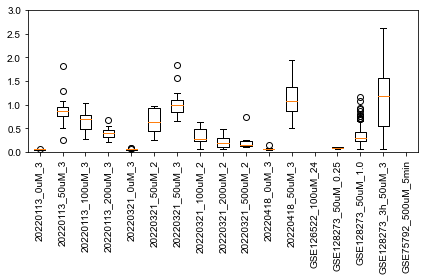

In [43]:
names = []
array = []
for run, d1 in dat1.groupby(by="Run"):
    for s4u, d2 in d1.groupby(by="4sU"):
        for time, d3 in d2.groupby(by="Time"):
            # print(run, s4u, time, len(d3), sep="\t")
            name = "%s_%duM_%s" % (run, s4u, time)
            names.append(name)
            array.append(d3["Pc"].values)
xs = np.arange(len(array))

plt.figure()
plt.boxplot(array, positions=xs)
plt.xticks(xs, names, rotation=90)
plt.ylim(0, 3)
plt.tight_layout()
plt.show()